In [1]:
pwd

'/home/met/ug/16144001/ml_18/Zero-Shot-Object-Detection-Segmentation'

In [2]:
ls

annotations_prepocessing.ipynb  model.ipynb
background_boxes.ipynb          __pycache__/
bcolz_array_iterator.py         README.md
Box_output1.png                 selective_search.py
coco_seen_train_features.bc/    train_seen_img_box_cat.json
color_images.json               train_unseen_img_box_cat.json
feature_extraction.ipynb        val_seen_img_box_cat.json
LR_SGD.py                       val_unseen_img_box_cat.json
mnist_basic_model.ipynb         visual_genome_feature_extraction.ipynb
mnist_basic_train.ipynb


In [4]:
import cv2
from matplotlib import patches
import matplotlib.pyplot as plt

In [30]:
%%time
# If image path and f/q is not passed as command
# line arguments, quit and display help message
# if len(sys.argv) < 3:
#     print(__doc__)
#     sys.exit(1)

fpath = '/home/met/ug/16144001/Downloads/vg/VG_100K/'
fname = '2.jpg'

# speed-up using multithreads
cv2.setUseOptimized(True);
cv2.setNumThreads(4);

mode = 'f'
# read image
im = cv2.imread(fpath+fname)
# resize image
newHeight = 224
newWidth = 224
# newWidth = int(im.shape[1]*224/im.shape[0])
im = cv2.resize(im, (newWidth, newHeight))    

# create Selective Search Segmentation Object using default parameters
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

# set input image on which we will run segmentation
ss.setBaseImage(im)

# Switch to fast but low recall Selective Search method
if (mode == 'f'):
    ss.switchToSelectiveSearchFast()

# Switch to high recall but slow Selective Search method
elif (mode == 'q'):
    ss.switchToSelectiveSearchQuality()
# if argument is neither f nor q print help message

# run selective search segmentation on input image
rects = ss.process()
print('Total Number of Region Proposals: {}'.format(len(rects)))

# number of region proposals to show

# increment to increase/decrease total number
# of reason proposals to be shown
# increment = 50

Total Number of Region Proposals: 732
CPU times: user 841 ms, sys: 7.02 ms, total: 848 ms
Wall time: 561 ms


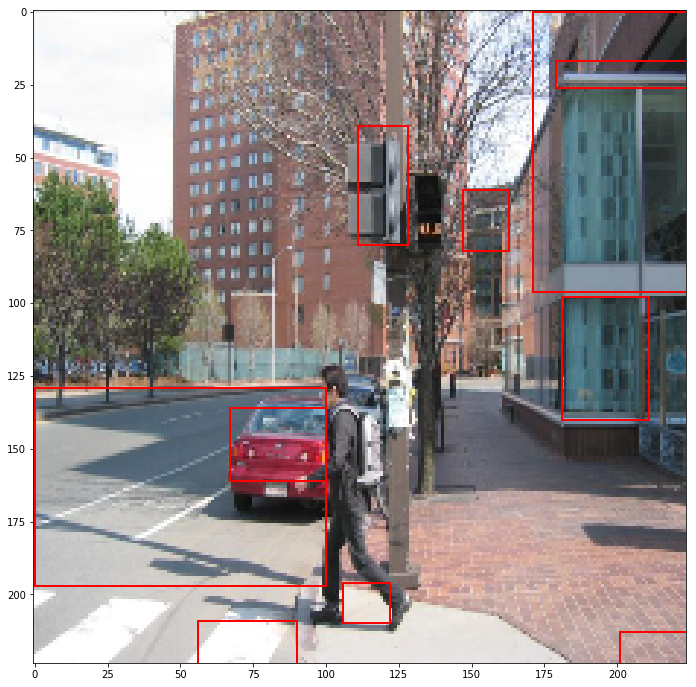

In [31]:
numShowRects = 10
fig = plt.figure()
fig.set_size_inches((12,12))
for i, rect in enumerate(rects):
    # draw rectangle for region proposal till numShowRects
    if (i < numShowRects):
        x, y, w, h = rect
    ax = plt.gca()
    rec = patches.Rectangle((x,y), w, h, edgecolor='r', fill=False, linewidth=2)
    ax.add_patch(rec)
ax.imshow(im[:,:,::-1])

In [ ]:
# import the necessary packages
import numpy as np

# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes	
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")